In [395]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.ar_model import AutoReg
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [396]:
census = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
test= pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv",parse_dates=['first_day_of_month'])
train=pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv",parse_dates=["first_day_of_month"])


In [397]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

check_outlier(train, "microbusiness_density")

True

In [398]:
train=remove_outlier(train, "microbusiness_density")

<AxesSubplot:ylabel='Frequency'>

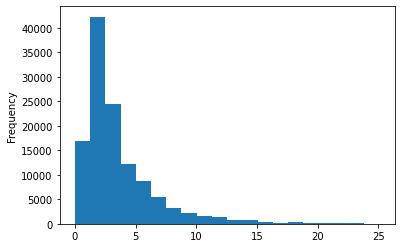

In [399]:
train["microbusiness_density"].plot(kind="hist",bins=20)

<AxesSubplot:xlabel='cfips', ylabel='microbusiness_density'>

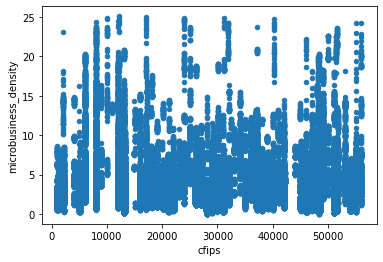

In [400]:
train.plot.scatter(x="cfips",y="microbusiness_density")

In [401]:
test = pd.merge(test, census, how="left", on="cfips")
train = pd.merge(train, census, how="left", on="cfips")

<AxesSubplot:xlabel='first_day_of_month'>

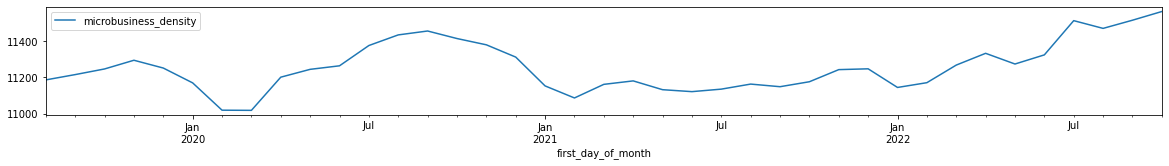

In [402]:
train.groupby("first_day_of_month").sum().plot.line(y="microbusiness_density", figsize=(20,2))

<AxesSubplot:>

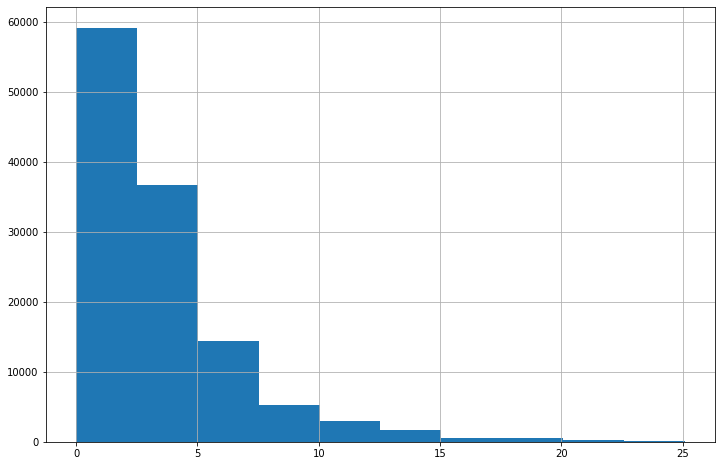

In [403]:
train["microbusiness_density"].hist(figsize=(12,8))

In [404]:
def create_date_features(df):
    df['month'] = df.first_day_of_month.dt.month
    df['day_of_month'] = df.first_day_of_month.dt.day
    df['day_of_year'] = df.first_day_of_month.dt.dayofyear
    df['week_of_year'] = df.first_day_of_month.dt.weekofyear
    df['day_of_week'] = df.first_day_of_month.dt.dayofweek
    df['year'] = df.first_day_of_month.dt.year
    df["is_wknd"] = df.first_day_of_month.dt.weekday // 4
    df['is_month_start'] = df.first_day_of_month.dt.is_month_start.astype(int)
    df['is_month_end'] = df.first_day_of_month.dt.is_month_end.astype(int)
    return df

train = create_date_features(train)
test=create_date_features(test)

In [405]:
#train = pd.concat([train, test], sort=False)

In [406]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["cfips"])['microbusiness_density'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

#train = lag_features(train, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [407]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [408]:
test.head()

,row_id,cfips,first_day_of_month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,1001_2022-11-01,1001,2022-11-01,76.600,78.900,80.600,82.700,85.500,14.500,15.900,16.100,16.700,16.400,2.100,2.000,2.300,2.300,2.100,1.300,1.100,0.700,0.600,1.100,55317,58786.000,58731,57982.000,62660.000,11,1,305,44,1,2022,0,1,0
1,1003_2022-11-01,1003,2022-11-01,74.500,78.100,81.800,85.100,87.900,20.400,20.700,21.000,20.200,20.600,3.200,3.400,3.700,3.400,3.500,1.400,1.300,1.400,1.000,1.300,52562,55962.000,58320,61756.000,64346.000,11,1,305,44,1,2022,0,1,0
2,1005_2022-11-01,1005,2022-11-01,57.200,60.400,60.500,64.600,64.600,7.600,7.800,7.600,7.300,6.700,2.700,2.500,2.700,2.600,2.600,0.500,0.300,0.800,1.100,0.800,33368,34186.000,32525,34990.000,36422.000,11,1,305,44,1,2022,0,1,0
3,1007_2022-11-01,1007,2022-11-01,62.000,66.100,69.200,76.100,74.600,8.100,7.600,6.500,7.400,7.900,1.000,1.400,1.500,1.600,1.100,1.200,1.400,1.600,1.700,2.100,43404,45340.000,47542,51721.000,54277.000,11,1,305,44,1,2022,0,1,0
4,1009_2022-11-01,1009,2022-11-01,65.800,68.500,73.000,79.600,81.000,8.700,8.100,8.600,8.900,9.300,4.500,4.400,4.500,4.400,4.500,1.300,1.400,0.900,1.100,0.900,47412,48695.000,49358,48922.000,52830.000,11,1,305,44,1,2022,0,1,0


In [409]:
def add_lags(df):
    target_map=df["microbusiness_density"].to_dict()
    df["lag1"] = (df.first_day_of_month-pd.Timedelta("178 days")).map(target_map)
    df["lag2"] = (df.first_day_of_month-pd.Timedelta("364 days")).map(target_map)
    df["lag3"] = (df.first_day_of_month-pd.Timedelta("728 days")).map(target_map)
    return df

#train = add_lags(train)


In [410]:
#test=add_lags(test)

In [411]:
test.head()

,row_id,cfips,first_day_of_month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,1001_2022-11-01,1001,2022-11-01,76.600,78.900,80.600,82.700,85.500,14.500,15.900,16.100,16.700,16.400,2.100,2.000,2.300,2.300,2.100,1.300,1.100,0.700,0.600,1.100,55317,58786.000,58731,57982.000,62660.000,11,1,305,44,1,2022,0,1,0
1,1003_2022-11-01,1003,2022-11-01,74.500,78.100,81.800,85.100,87.900,20.400,20.700,21.000,20.200,20.600,3.200,3.400,3.700,3.400,3.500,1.400,1.300,1.400,1.000,1.300,52562,55962.000,58320,61756.000,64346.000,11,1,305,44,1,2022,0,1,0
2,1005_2022-11-01,1005,2022-11-01,57.200,60.400,60.500,64.600,64.600,7.600,7.800,7.600,7.300,6.700,2.700,2.500,2.700,2.600,2.600,0.500,0.300,0.800,1.100,0.800,33368,34186.000,32525,34990.000,36422.000,11,1,305,44,1,2022,0,1,0
3,1007_2022-11-01,1007,2022-11-01,62.000,66.100,69.200,76.100,74.600,8.100,7.600,6.500,7.400,7.900,1.000,1.400,1.500,1.600,1.100,1.200,1.400,1.600,1.700,2.100,43404,45340.000,47542,51721.000,54277.000,11,1,305,44,1,2022,0,1,0
4,1009_2022-11-01,1009,2022-11-01,65.800,68.500,73.000,79.600,81.000,8.700,8.100,8.600,8.900,9.300,4.500,4.400,4.500,4.400,4.500,1.300,1.400,0.900,1.100,0.900,47412,48695.000,49358,48922.000,52830.000,11,1,305,44,1,2022,0,1,0


In [412]:
X = train.drop(columns={"row_id", "first_day_of_month", "microbusiness_density", "county", "state", "active","cfips"})
y = train["microbusiness_density"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

x_pred = test.drop(columns={"row_id", "first_day_of_month","cfips"})

In [413]:
model = XGBRegressor(n_estimators=500, eval_metric=smape, early_stopping_rounds=30, learning_rate=0.2)
model.fit(x_train, y_train,  
             eval_set=[(x_valid, y_valid)],
             verbose=100)

y_pred = model.predict(x_pred)

[0]	validation_0-rmse:3.72652	validation_0-smape:87.20266
[100]	validation_0-rmse:0.68085	validation_0-smape:14.69899


KeyboardInterrupt: 

In [ ]:
test["microbusiness_density"] = pd.Series(y_pred).astype(float)
test[["row_id", "microbusiness_density"]].to_csv("submission.csv", index=False)